Imports


In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Load data

In [2]:
data_path = "../udataset/wealth_data.csv"
df = pd.read_csv(data_path)
df['state']

0      alabama
1      alabama
2      alabama
3      alabama
4      alabama
        ...   
671    wyoming
672    wyoming
673    wyoming
674    wyoming
675    wyoming
Name: state, Length: 676, dtype: object

Do PCA on data

In [3]:
features = df.drop(columns=["state", "year"])
no_components = 2
pca = PCA(n_components=no_components)
pca_features = pca.fit_transform(features)
df = pd.concat([df[["state", "year"]], pd.DataFrame(pca_features)], axis=1)
df

state  year             0           1
0    alabama  2010 -16193.774059 -319.701593
1    alabama  2011 -15337.525341 -225.643391
2    alabama  2012 -15110.992278 -211.511291
3    alabama  2013 -15017.792477 -206.336899
4    alabama  2014 -14759.274098 -193.176119
..       ...   ...           ...         ...
671  wyoming  2018   4007.205538 -165.697701
672  wyoming  2019   5788.204539 -192.760203
673  wyoming  2020   7041.898108 -254.836184
674  wyoming  2021   9745.605055 -107.821019
675  wyoming  2022  14245.670172   56.686205

[676 rows x 4 columns]

In [4]:
# Drop the state column
state = df['state']
features = df.drop(['state'], axis=1)

start_year = df['year'].min()
end_year = df['year'].max()

2022

Predict clusters

In [4]:
df['cluster'] = pd.NA
num_clusters = 3
init = None
for year in range(start_year, end_year + 1):
    if init is None:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    else:
        kmeans = KMeans(n_clusters=num_clusters, init=init, random_state=0)

    year_features = features[features['year'] == year].drop(['year'], axis=1)
    cluster = kmeans.fit_predict(year_features)
    df.loc[df['year'] == year, 'cluster'] = cluster
    init = kmeans.cluster_centers_

    print(f"Silhouette score for {year}: {silhouette_score(year_features, cluster)}")
    print(f"Inertia: {kmeans.inertia_}")

df

Silhouette score for 2010: 0.44597119871227286
Inertia: 0.7159380123911897
Silhouette score for 2011: 0.4520221550582939
Inertia: 0.724546677546563
Silhouette score for 2012: 0.4314888289918377
Inertia: 0.7548765639460165
Silhouette score for 2013: 0.43237761732594393
Inertia: 0.7410145057813595
Silhouette score for 2014: 0.4480928093834431
Inertia: 0.6892617191904156
Silhouette score for 2015: 0.4710824556447937
Inertia: 0.6350396920023978
Silhouette score for 2016: 0.4778624163209776
Inertia: 0.6044885006571081
Silhouette score for 2017: 0.4818243387682888
Inertia: 0.592716351843862
Silhouette score for 2018: 0.4912543795991943
Inertia: 0.5896654191087778
Silhouette score for 2019: 0.49922905249242694
Inertia: 0.5950567140016546
Silhouette score for 2020: 0.5455367505311044
Inertia: 0.585856260144061
Silhouette score for 2021: 0.5090341543928549
Inertia: 0.7594379596387253
Silhouette score for 2022: 0.5219336857412564
Inertia: 0.8997662321153589


state  year         0         1 cluster
0    alabama  2010  0.245902 -0.074885       2
1    alabama  2011  0.235786 -0.049152       2
2    alabama  2012  0.239269 -0.038398       2
3    alabama  2013  0.244974 -0.029583       2
4    alabama  2014  0.245313 -0.021898       2
..       ...   ...       ...       ...     ...
671  wyoming  2018 -0.077746 -0.058789       0
672  wyoming  2019 -0.096779 -0.057113       0
673  wyoming  2020 -0.108489 -0.064569       2
674  wyoming  2021 -0.152143 -0.032131       2
675  wyoming  2022 -0.215805  0.011990       2

[676 rows x 5 columns]

Reformat and name colums

In [5]:
# Move the cluster column to the start
cols = df.columns.tolist()
df = df[[cols[0]] + [cols[1]] +[ cols[-1]] + cols[2:-1]]

# Rename the principal components
pca_mapping = {i: f"PC{i+1}" for i in range(no_components)}
df = df.rename(columns=pca_mapping)

# Convert all cluster 2 to cluster 1
df.loc[df['cluster'] == 2, 'cluster'] = 1

Change cluster value to be descriptive

In [6]:
print(df[(df['cluster'] == 1) & (df['year'] == 2021)]['state'])

# Change 1 to poorer and 0 to richer
df['cluster'] = df['cluster'].replace({1: 'poorer', 0: 'richer'})

11            alabama
37            arizona
50           arkansas
102          delaware
128           florida
141           georgia
167             idaho
193           indiana
206              iowa
219            kansas
232          kentucky
245         louisiana
258             maine
297          michigan
323       mississippi
336          missouri
349           montana
362          nebraska
375            nevada
414        new mexico
440    north carolina
466              ohio
479          oklahoma
505      pennsylvania
518       puerto rico
531      rhode island
544    south carolina
557      south dakota
570         tennessee
583             texas
609           vermont
648     west virginia
661         wisconsin
674           wyoming
Name: state, dtype: object


Add visualization of groups

Text(0.5, 1.0, 'KMeans Clustering of States for Health Data (All years)')

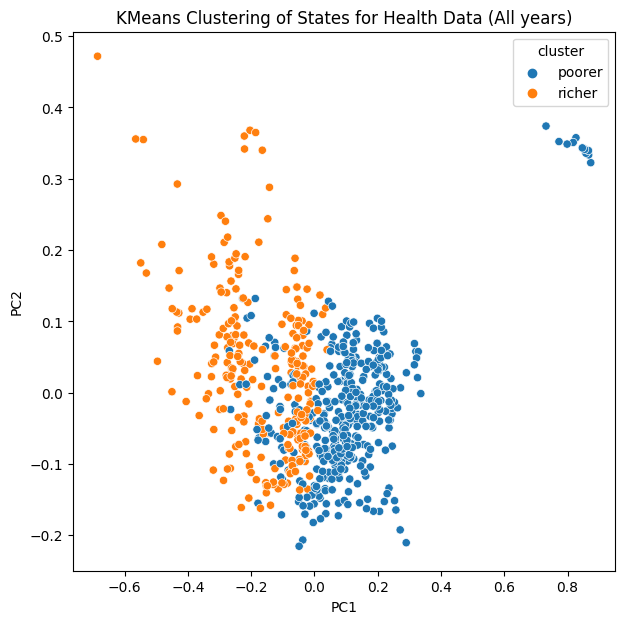

In [7]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.title("KMeans Clustering of States for Health Data (All years)")

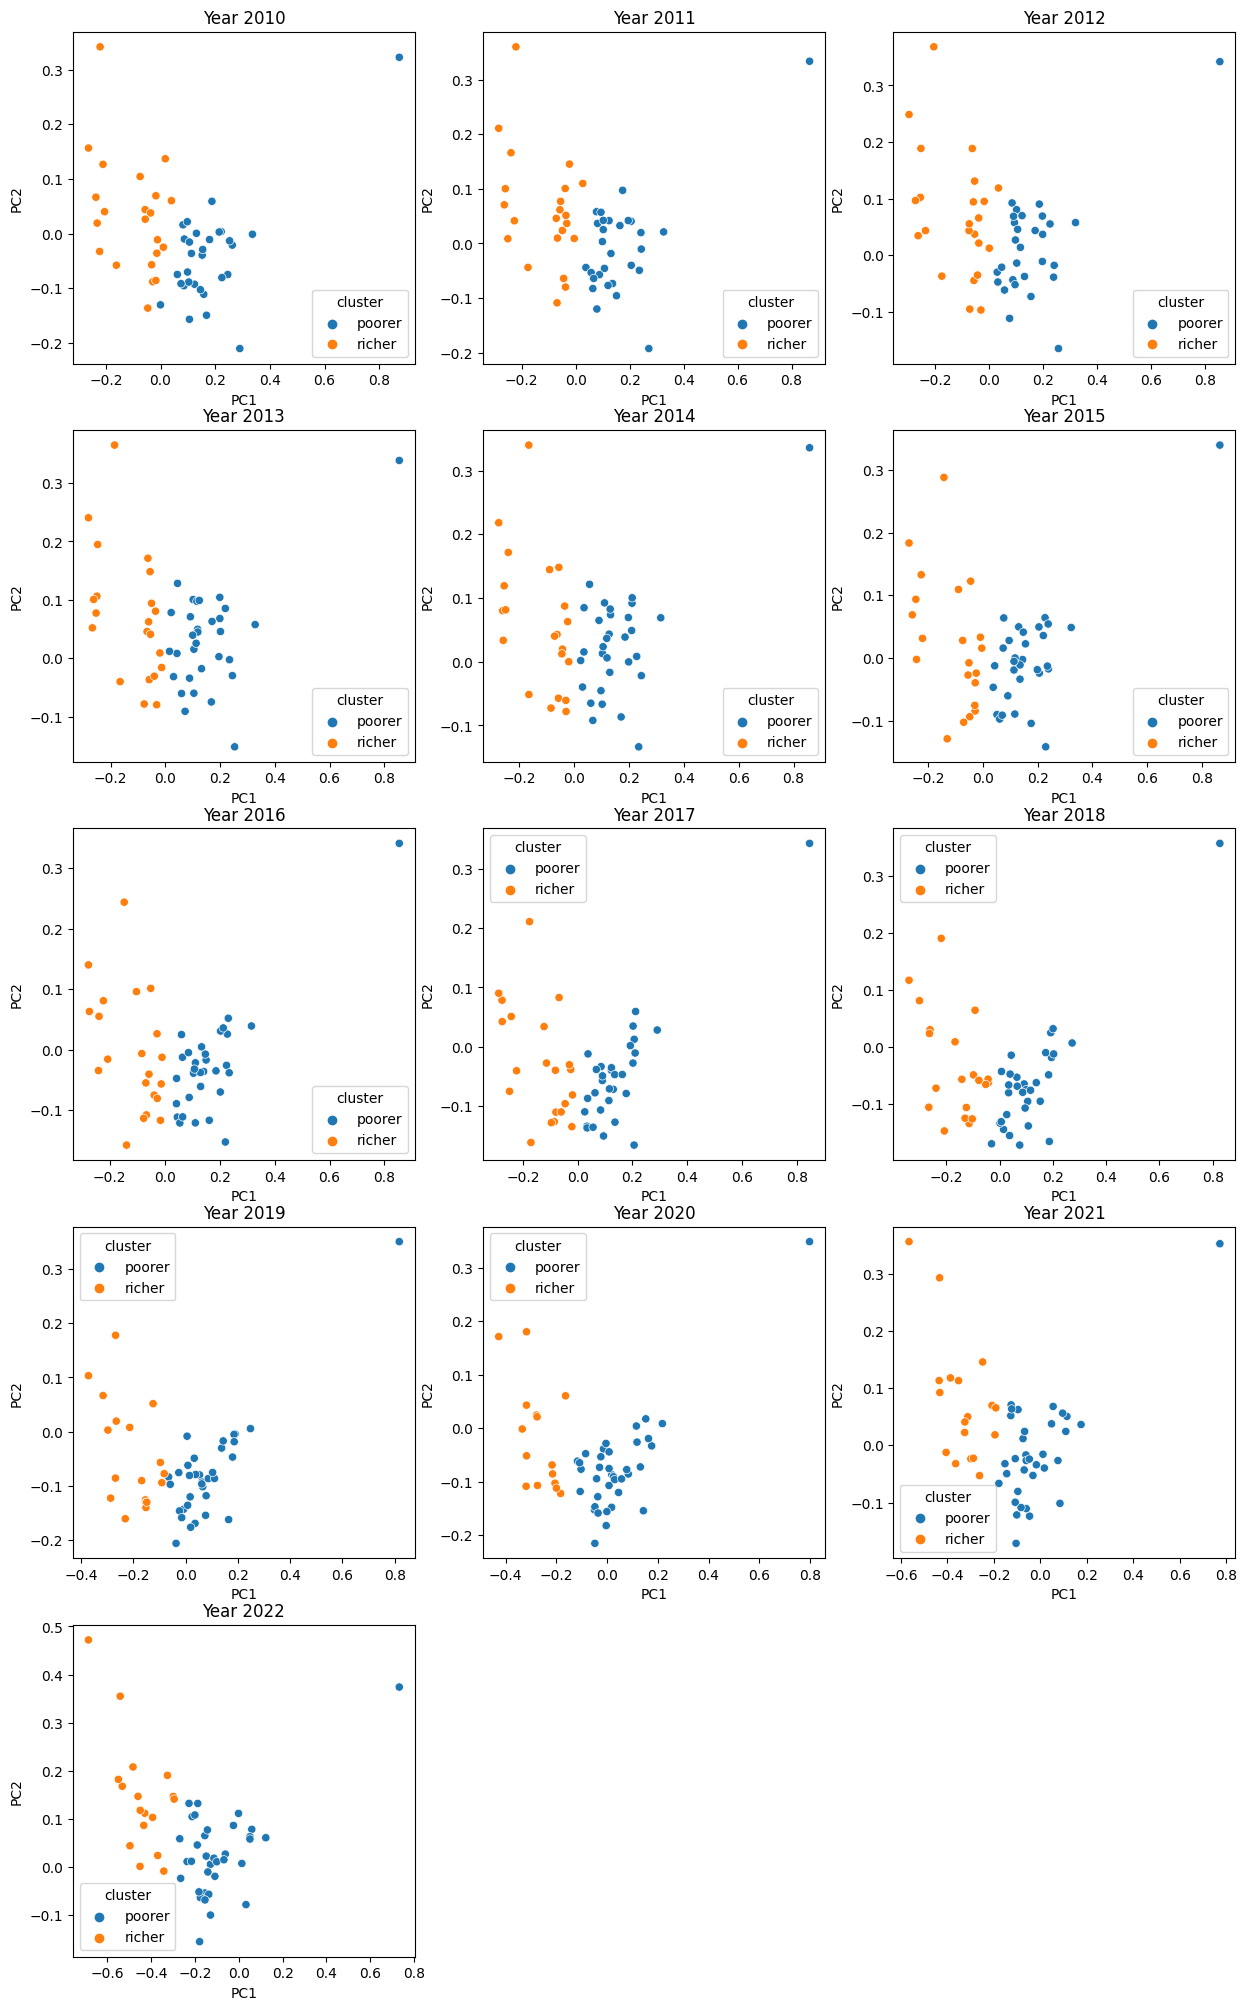

In [8]:
num_years = end_year - start_year + 1
col = 3
row = num_years // col + 1
plt.figure(figsize=(5 * col, 5 * row))

for i, year in enumerate(range(start_year, end_year + 1)):
    plt.subplot(row, col, i + 1)
    sns.scatterplot(data=df[df['year'] == year], x='PC1', y='PC2', hue='cluster', palette='tab10')
    plt.title(f"Year {year}")

In [9]:
NEWNAME = 'wealth_data_clustered.csv'
df.to_csv('../udataset/' + NEWNAME, index=False)